# 1. Random Forest from scratch
I am going to understand how random forests are working by creating a complete random forest model and related random forest functionality. We are then going to compare this to the sklearn RandomForest.

In [ ]:
# load packages

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics
import os

## 1.1 Load in bulldozer pricing data

In [2]:
print(os.getcwd())
os.chdir(r"/Users/nyatchen/Desktop/PyProjects/FastAI/tmp") 
df_raw = pd.read_feather('raw')

/Users/nyatchen/Desktop/PyProjects/Random Forest from Scratch


In [4]:
df_bull = df_raw.copy()

# Splitting dependent variable
#y = df.SalePrice
#df.drop('SalePrice', axis = 1, inplace = True)

# Fixing continuous missing values and numeric codes (-1 to 0)
import pandas.api.types as ptypes
for n,c in df_bull.items():
    if ptypes.is_numeric_dtype(c):
        if pd.isnull(c).sum(): 
            df_bull[n+'_na'] = pd.isnull(c)
            df_bull[n] = c.fillna(c.median())
    if not ptypes.is_numeric_dtype(c):
        df_bull[n] = c.cat.codes+1
#df_bull = df_bull.sort_values(by = 'saleElapsed')
#df_bull = df_bull.reset_index(drop=True)
df_bull.shape

(401125, 67)

In [5]:
df_bull.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,3,950,...,320,False,False,False,False,False,False,1163635200000000000,False,False
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,3,1725,...,86,False,False,False,False,False,False,1080259200000000000,False,False
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,1,331,...,57,False,False,False,False,False,False,1077753600000000000,False,False
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,1,3674,...,139,False,False,False,False,False,False,1305763200000000000,False,False
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,2,4208,...,204,False,False,False,False,False,False,1248307200000000000,False,False


In [6]:
y_trn = df_bull.SalePrice
df_trn = df_bull.drop(['SalePrice'], axis = 1)

In [64]:
def split_vals(a, n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn) - n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [65]:
x_sub = X_train[['YearMade', 'MachineHoursCurrentMeter']]; x_sub.shape

(389125, 2)

## 1.2 Basic data structure
The idea is to write this top-down: start by assuming that everything we need already exists. So we start with assuming there already is a DecisionTree and we start by aggregating individual trees. Crudly, we delay the actual thinking as much as possible, and assume everything we need already is written (will be written later).


In [66]:
class TreeEnsemble():
    ''' This is a class of tree enemble that holds initial hyperparameters, trainings sets, methods (creating a tree,
    predicting)'''
    
    def __init__(self, x, y, n_trees, sample_sz, min_leaf = 5):
        ''' Holds initial set of hyperparameters (sample size and min number of samples in a leaf), training sets 
        and creates a set of trees'''
        np.random.seed(101)
        self.x, self.y, self.sample_sz, self.min_leaf = x, y, sample_sz, min_leaf
        self.trees = [self.create_tree() for i in range(n_trees)]
    
    def create_tree(self):
        ''' Returns a object of a DecisionTree class and passes to it initial hyperparameters and a permuted subset of 
        training sets; contains number of random instances with replacement (bootstrap is with replacement) '''
        rnd_idxs = np.random.permutation(len(self.y))[:self.sample_sz]
        return DecisionTree(self.x.iloc[rnd_idxs], self.y[rnd_idxs], min_leaf = self.min_leaf)
    
    def predict(self, x):
        ''' Returns the average of each tree predictions (each tree is of a DecisionTree class and has an associated
        predict method to it) '''
        return np.mean([t.predict for t in self.trees], axis = 0)

In [67]:
class DecisionTree():
    ''' This is a class of decision trees that uses hyperparameters, training sets, methods (finds variable splits,
    finds better splits, predicts on data, ...) 
    Does not have randomness in it'''
    
    def __init__(self, x, y, idxs = None, min_leaf = 5):
        ''' Holds initial set of hyperparameters (sample size and min number of samples in a leaf), training sets, 
        number of rows in the tree (which indexes), number of columns, prediction value for a tree, 
        At the moment of instantiating - the prediction value is the average of the target sample y[idxs], and the
        score (aka how effective was the split, unless it is a leaf - then infininty) is the infinity '''
        
        if idxs is None: idxs = np.arange(len(y))
        self.x, self.y, self.idxs, self.min_leaf = x, y, idxs, min_leaf
        self.n, self.c = len(idxs), x.shape[1]
        self.val = np.mean(y.iloc[idxs])
        self.score = float('inf') # after we have the score we need to identify where we are going to split the data
        self.find_varsplit() # initiate this right away, so the score is no longer 'inf' - it will be inf for other 
                             # trees down the line!
        
    def find_varsplit(self):
        ''' Finds a variable to split on by just going through all of them (no feature selection, aka in sklearn
        equivalent of setting max_features = 1) '''
        for i in range(self.c): self.find_better_split(i)
    
    def find_better_split(self, var_idx): pass
    
    @property # decorator - no need to include parenthesis (more info for the function we are defining)
    def split_name(self): return self.x.columns[self.var_idx]
    
    @property
    def split_col(self): return self.x.values[self.idxs, self.var_idx]
    
    @property 
    def is_leaf(self): return self.score == float('inf')
    
    def __repr__(self):
        ''' Message we get when selecting out a single tree '''
        s = f'n: {self.n}; val:{self.val}'
        if not self.is_leaf: # if not a leaf node we will also print out score, split and split name
            s += f'; score:{self.score}; split:{self.split}; var:{self.split_name}'
        return s

In [68]:
m = TreeEnsemble(X_train, y_train, n_trees = 10, sample_sz = 1000, min_leaf = 3)

In [69]:
m.trees[0]

n: 1000; val:10.103329768562391

## 1.3 Single branch

### 1.3.1 Find best split given variable

In [70]:
ens = TreeEnsemble(x_sub, y_train, 1, 1000)
tree_ = ens.trees[0]
x_samp, y_samp = tree_.x, tree_.y
print(x_samp.shape)
x_samp.columns

(1000, 2)


Index(['YearMade', 'MachineHoursCurrentMeter'], dtype='object')

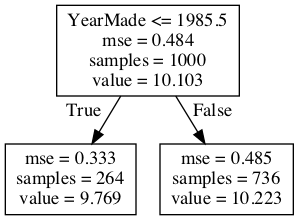

In [71]:
m = RandomForestRegressor(n_estimators = 1, max_depth = 1, bootstrap = False)
m.fit(x_samp, y_samp)

# Load libraries

from IPython.display import Image  
from sklearn import tree
import pydotplus

# Create DOT data
dot_data = tree.export_graphviz(m.estimators_[0], out_file=None, 
                                feature_names=x_samp.columns)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

Reason why sklearn has 1985.5 is because they are averaging the points they are iterating over and we are not.

In [72]:
def find_better_split(self, var_idx):
    ''' Takes a variable and finds a numerical split for this variable '''
    x, y = self.x.values[self.idxs, var_idx], self.y.iloc[self.idxs]
    
    for i in range(1, self.n-1):
        # go through every single value and compute the score if we were to branch out on every 
        # single value in that column. The score is the information gain - how much more do we know about
        # the data because we split in into these groups, based on that split. There are lots of ways to
        # calc it ~ rmse is one of them. Similar to improved RMSE is splitting into groups with least amount of
        # variance! Which is just caling std -> can do a math proof for that one
        lhs = x <= x[i]
        rhs = x > x[i]
        if rhs.sum() < self.min_leaf or lhs.sum() < self.min_leaf: continue # aka bad split since there is nothing in rhs group
        lhs_std = y[lhs].std()
        rhs_std = y[rhs].std()
        curr_score = lhs_std*lhs.sum() + rhs_std*rhs.sum()
        if curr_score < self.score: 
            # self.score conatins scores from previous columns and is continually updated
            # below as we find better column and value in that column to split on
            self.var_idx, self.score, self.split = var_idx, curr_score, x[i]

In [73]:
find_better_split(tree_,1)
tree_

n: 1000; val:10.103329768562391; score:686.9423003332289; split:2191.0; var:MachineHoursCurrentMeter

In [74]:
find_better_split(tree_,0)
tree_

n: 1000; val:10.103329768562391; score:665.1907703901816; split:1985.0; var:YearMade

In [75]:
%prun find_better_split(tree_, 1)

We have matched to the sklearn Decision Tree! YearMade 1985 is a better split with an average value of 10.103 (just the mean)

### 1.3.2 Speeding things up
The computaitonal compexity of this code is $n^2$. Because there is a loop - here is $n$. Then we need to compaare each element against a constant - $n$. Thus we have $n*n$.

sorting algorithm is $n*log(n)$

In [76]:
import math
def std_agg(cnt, s1, s2): return math.sqrt((s2/cnt) - (s1/cnt)**2)

def find_better_split(self, var_idx):
    x, y = self.x.values[self.idxs, var_idx], self.y.values[self.idxs]
    
    sort_idx = np.argsort(x)
    sort_y, sort_x = y[sort_idx], x[sort_idx]
    rhs_cnt, rhs_sum, rhs_sum2 = self.n, sort_y.sum(), (sort_y**2).sum()
    lhs_cnt, lhs_sum, lhs_sum2 = 0, 0., 0.
    
    for i in range(0, self.n - self.min_leaf -1): 
        # reason for subtracting min_leaf is becuase initially everything
        # is in the right hand side, so as we loop through every observation we
        # want to make sure that we have minimum sample on the right hand side left
        xi, yi = sort_x[i], sort_y[i]
        lhs_cnt += 1; rhs_cnt -= 1
        lhs_sum += yi; rhs_sum -= yi
        lhs_sum2 += yi**2; rhs_sum2 -= yi**2
        if i < self.min_leaf or xi == sort_x[i+1]:
            continue
        
        lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
        rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
        curr_score = lhs_std*lhs_cnt + rhs_std*rhs_cnt
        if curr_score < self.score:
            self.var_idx, self.score, self.split = var_idx, curr_score, xi
        

In [77]:
%timeit find_better_split(tree_, 0)
tree_

2.68 ms ± 118 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


n: 1000; val:10.103329768562391; score:664.5532285011903; split:1985.0; var:YearMade

In [78]:
# Assign find_better_split to DecisionTree.find_better_split
DecisionTree.find_better_split = find_better_split

In [79]:
tree_ = TreeEnsemble(x_sub, y_train, n_trees = 1, sample_sz = 1000).trees[0]; tree_

n: 1000; val:10.103329768562391; score:664.5532285011903; split:1985.0; var:YearMade

## 1.4 Full single tree
Let's go one level deeper

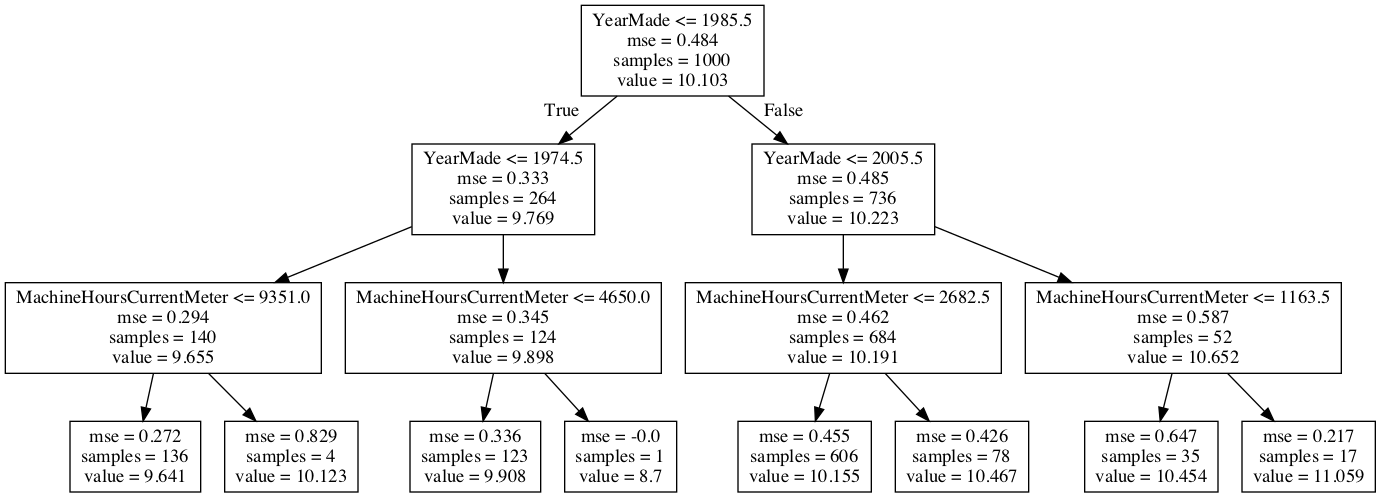

In [80]:
m = RandomForestRegressor(n_estimators=1, max_depth = 3, bootstrap = False)
m.fit(x_samp, y_samp)

# Load libraries

from IPython.display import Image  
from sklearn import tree
import pydotplus

# Create DOT data
dot_data = tree.export_graphviz(m.estimators_[0], out_file=None, 
                                feature_names=x_samp.columns)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

We already have find_varsplit function within DecisionTree Class, it just loops over the variables and finds the best numerical split for each column. We need to go a bit further than that. Not only do we have to go through each column and see if there is a better split in this node, but we also need to see if there are better splits in the left and the right hand sides that we have just created. In other words, the right hand side and the left hand side should become decision trees themselves.

There should be no difference between creating a root tree split vs a child tree split. From the picture above, the process of determining the split of YearMade <= 1981.5 should be identical to determining the next split for the rhs: YearMade <= 2004.5. Thus we are just creating DecisionTrees at each child node going forward.

In [81]:
def find_varsplit(self):
    for i in range(self.c): self.find_better_split(i)
    if self.is_leaf: return # if it is a leaf - we are done we are at the bottom of the tree
    x = self.split_col # property that returns a column we decided to split on, now we are going to split
                       # the entire training data set into 2: lhs and rhs (observations associated with that split
                       # column values that are greater than and less than or equal to the split value)
    lhs = np.nonzero(x <= self.split)[0] # storing indexes of the 'True's to reduce memory requirements
    rhs = np.nonzero(x >  self.split)[0]
    self.lhs = DecisionTree(self.x, self.y, self.idxs[lhs], self.min_leaf)
    self.rhs = DecisionTree(self.x, self.y, self.idxs[rhs], self.min_leaf)

In [82]:
DecisionTree.find_varsplit = find_varsplit # we have a circular recursion which stops when we have self.is_leaf True!

# Recursion: we create varsplit to define DecisionTree, and in creating varsplit we call on the DecisionTree

In [83]:
tree_ = TreeEnsemble(x_sub, y_train, n_trees = 1, sample_sz=1000).trees[0]; tree_

n: 1000; val:10.103329768562391; score:664.5532285011903; split:1985.0; var:YearMade

In [84]:
tree_.lhs

n: 264; val:9.768995188767295; score:148.71194846429808; split:1974.0; var:YearMade

In [85]:
tree_.lhs.lhs

n: 140; val:9.654839898649724; score:75.00367432066284; split:4451.0; var:MachineHoursCurrentMeter

## 1.5 Predictions
There is nothing in decision tree to predict yet!

In [86]:
cols = ['MachineID', 'YearMade', 'MachineHoursCurrentMeter', 'ProductSize', 'Enclosure', 'Coupler_System', 'saleYear']

In [87]:
tree_ = TreeEnsemble(X_train[cols], y_train, 1, 1000).trees[0]
x_samp, y_samp = tree_.x, tree_.y

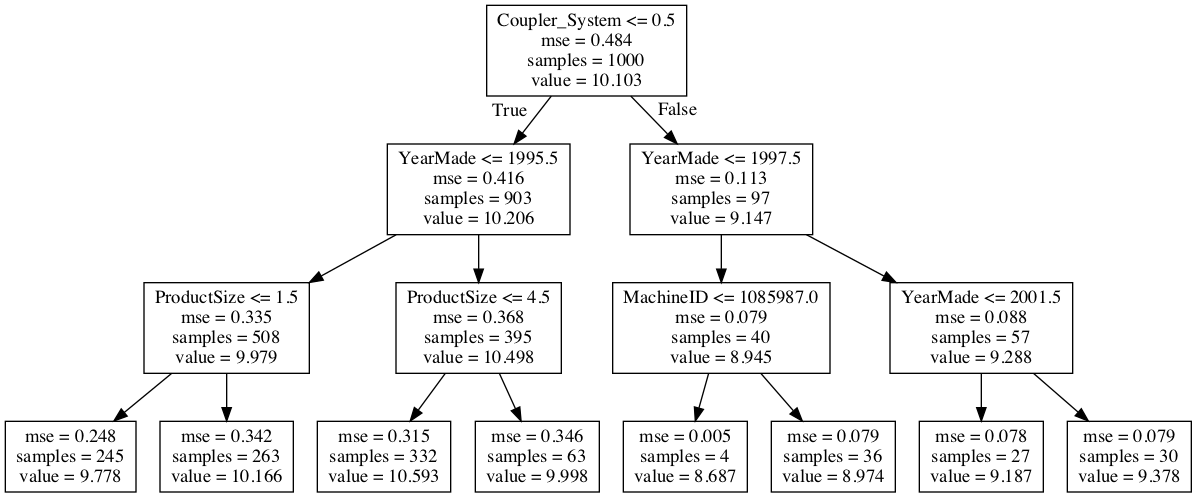

In [88]:
m = RandomForestRegressor(n_estimators=1, max_depth = 3, bootstrap = False)
m.fit(x_samp, y_samp)

# Load libraries

from IPython.display import Image  
from sklearn import tree
import pydotplus

# Create DOT data
dot_data = tree.export_graphviz(m.estimators_[0], out_file=None, 
                                feature_names=x_samp.columns)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

In [89]:
def predict(self, x): return np.array([self.predict_row(xi) for xi in x])
DecisionTree.predict = predict

Now all we need to do is predict row

In [90]:
def predict_row(self, xi):
    if self.is_leaf: return self.val # that's where the prediction is made! aka a point most similar
                                     # remember that we are doing this for each row
                                     # if it is not a leaf node than we need to figure out whether to go lhs or rhs
    t = self.lhs if xi[self.var_idx]<=self.split else self.rhs
    return t.predict_row(xi) # again we have recursion! 
                             # since we return a call to itself and this ends only if leaf exists
                             # now we pass a level deeper (self.lhs to predict_row, which, if it is not a leaf) will
                             # pass a level deeper (self.lhs)'s self.lhs and so on until getting to a leaf node

DecisionTree.predict_row = predict_row

In [91]:
preds = tree_.predict(X_valid[cols].values)

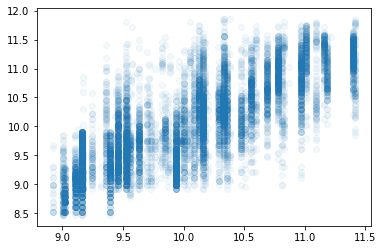

In [92]:
import matplotlib.pyplot as plt
plt.scatter(preds, y_valid, alpha = 0.05)

In [93]:
metrics.r2_score(preds, y_valid)

0.5365305964423108

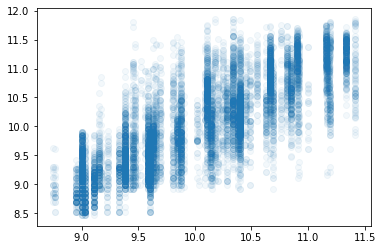

In [95]:
m = RandomForestRegressor(n_estimators=1, min_samples_leaf = 5, bootstrap = False)
m.fit(x_samp, y_samp)
preds = m.predict(X_valid[cols].values)
plt.scatter(preds, y_valid, alpha = 0.05)

In [97]:
metrics.r2_score(preds, y_valid)

0.5204764403225788

# 2. Putting it all together

# Archive

For some reason if we sort by saleElapsed first - we do not match with the sklearn

In [39]:
ens = TreeEnsemble(x_sub, y_train, 1, 1000)
tree_ = ens.trees[0]
x_samp, y_samp = tree_.x, tree_.y
print(x_samp.shape)
x_samp.columns

(1000, 2)


Index(['YearMade', 'MachineHoursCurrentMeter'], dtype='object')

In [38]:
def find_better_split_my(self, var_idx):
    ''' Takes a variable and finds a numerical split for this variable '''
    x, y = self.x.values[self.idxs, var_idx], self.y.iloc[self.idxs]
    i_split = [*range(0, self.n)]
    scores = []
    for i in i_split:
        # go through every single value and compute the score if we were to branch out on every 
        # single value in that column. The score is the information gain - how much more do we know about
        # the data because we split in into these groups, based on that split. There are lots of ways to
        # calc it ~ rmse is one of them. Similar to improved RMSE is splitting into groups with least amount of
        # variance! Which is just caling std -> can do a math proof for that one
        lhs = x <= x[i]
        rhs = x > x[i]
        if rhs.sum() < self.min_leaf or lhs.sum() < self.min_leaf: continue # aka bad split since there is nothing in rhs group
        lhs_std = y[lhs].std()
        rhs_std = y[rhs].std()
        curr_score = lhs_std*lhs.sum() + rhs_std*rhs.sum()
        scores.append(curr_score)

    i_split_min = i_split[np.argmin(scores)]
    print(np.argmin(scores))
    curr_score = scores[np.argmin(scores)]
    if curr_score < self.score: 
            # self.score conatins scores from previous columns and is continually updated
            # below as we find better column and value in that column to split on
            self.var_idx, self.score, self.split = var_idx, curr_score, x[i_split_min]

In [40]:
x, y = x_samp.values[:,0], y_samp.values
i_split = []
scores = []
for i in range(0,1000):
    # go through every single value and compute the score if we were to branch out on every 
    # single value in that column. The score is the information gain - how much more do we know about
    # the data because we split in into these groups, based on that split. There are lots of ways to
    # calc it ~ rmse is one of them. Similar to improved RMSE is splitting into groups with least amount of
    # variance! Which is just caling std -> can do a math proof for that one
    lhs = x <= x[i]
    rhs = x > x[i]
    if rhs.sum() < 3 or lhs.sum() < 3: continue # aka bad split since there is nothing in rhs group
    i_split.append(i)
    lhs_std = y[lhs].std()
    rhs_std = y[rhs].std()
    curr_score = lhs_std*lhs.sum() + rhs_std*rhs.sum()
    scores.append(curr_score)

i_split_min = i_split[np.argmin(scores)]
print(np.argmin(scores))
curr_score = scores[np.argmin(scores)]

162


In [41]:
vals = []
for i in range(len(i_split)):
    if scores[i] == min(scores):
        vals.append(x[i])

In [42]:
find_better_split_my(tree_,0)
tree_

160


n: 1000; val:10.1352274493206; score:673.3048946565671; split:1981.0; var:YearMade

In [43]:
find_better_split(tree_,0)
tree_

n: 1000; val:10.1352274493206; score:673.3048946565671; split:1981.0; var:YearMade